## Preface


This notebook aims to provide basic knowledge of Bayesian regression, as well as numerical examples. We will not go into the details of mathematicals, as I am not a mathmatician. I will give the final formulations directly, and then implement them with numerical examples.

## 1. The standard linear model 

The Bayesian analysis of the standard linear regression model with Gaussian noise is shown as Eq.(1).

$$
f(\mathbf{x}) = \mathbf{x}^T\mathbf{w}, \\
y = f(\mathbf{x}) + \epsilon, \tag{1}
$$

where $\mathbf{x}$ is the input vector, $\mathbf{w}$ is the weights (parameters) of the linear model, $f$ is the function value and $y$ is the observed target value, which is corrupted by a Gaussian noise $\epsilon$.

$$
\epsilon \sim \mathcal{N}(0, \delta_n^2). \tag{2}
$$

Next, I want to introduce four concepts that we need to know:

- **predictive distribution** $\mathcal{p}(mathbf{y}|\mathbf{x}$). This is the distribution we want to get, i.e., predict the distribution for $\mathbf{y}$ given obsevations $\mathbf{x}$.
- **likelihood** $\mathcal{p}(\mathbf{y}|\mathbf{x}, \mathbf{w})$. The probability distribution of an observation $\mathbf{y}$ conditioned on current parameters $\mathbf{w}$ and a set of input data (features) $\mathbf{x}$.
- **prior** $\mathcal{p}(\mathbf{w})$. Prior distribution of the model parameters. Choosing a prior is important as it can add regularization to our model. (Note: the prior should be chosen as the *conjugate* for the *likelihood*.)
- **posterior distribution** $\mathcal{p}(\mathbf{w}|\mathbf{x}, \mathbf{y})$. The posterior distributon for $\mathbf{w}$ given a set of data $\mathbf{x}$ and the target value $\mathbf{y}$. We can not compute this distribution directly, but it can be computed using Bayes' rule. 

### 2. Formulations
Now I will give the mathematical formulations of the distributon described above.
Suppose $X \in \mathcal{R}^{N \times (D+1)}$, where $N$ is the number of observations and $D$ represents the number of features (The bias is directly concatenated in to $X$, the same things happends for the parameters $\mathbf{w}$). $\mathbf{y} \in \mathcal{R}^{N \times 1}$ is the target value, and $\mathbf{w} \in \mathcal{R}^{(D+1) \times 1}$ is the parameters. ( the dimension for the bias is included.)

- **Likelihood**
$$
\mathcal{p}(X, \mathbf{w}) = \prod_{i=1}^{n}\frac{1}{\sqrt{2\pi}w_n}\mathcal{p}(y_i|\mathbf{x}_i, \mathbf{w}) \sim \mathcal{N}(X\mathbf{w}, \delta_n^2I).
$$

- **prior**
$$
\mathbf{\theta} \sim \mathcal{N}(\mathbf{0}, \textstyle \sum_p).
$$

- **posterior distributon**
$$
\mathcal{p}(\mathbf{\theta}| X, \mathbf{y}) \sim \mathcal{N}(\frac{1}{\delta_n^2}A^{-1}X^T\mathbf{y}, A^{-1}),
$$
where $\delta_n$ is the noise level in the target value $\mathbf{y}$, $\textstyle \sum_p$ is the covarience matrix for prior and $A = \delta_n^{-2}X^TX + \textstyle \sum_p^{-1}$.

## 3. Implement using python numpy

### 3.1 generate training dataset


In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


def linear_comb(X, params, variance, return_corrup=False):
    """ linear combination of the dataset `X`.
    """
    X_extend = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    y_true = X_extend.dot(params)
    if return_corrup:
        y_corrup = y_true + np.random.normal(scale=variance, size=y_true.shape)
        return X_extend, y_true, y_corrup
    
    return X_extend, y_true

def generate_dataset(train_num=20, train_var=0.5, params=[0.6, 0.4]):
    """ 
        train_num:  number of training observations `n`.
        params:     weights (shape: (d x 1)), `d` is the number of features
                    `d` = 2 in this tutorial.

    """
    if not isinstance(params, np.ndarray):
        params = np.array(params)
    params = params.reshape((-1, 1))
    # Training observations in [-1, 1)
    X = np.random.rand(train_num, 1) * 2 - 1
    X_extend, y_true, y_corrup = linear_comb(X, params, variance=train_var, return_corrup=True)

    ## Testing data
    X_test = np.linspace(-1, 1, 100).reshape(-1, 1)
    X_test_extend, y_test_true = linear_comb(X_test, params, variance=0, return_corrup=False)

    return (X_extend, y_corrup, y_true), (X_test_extend, y_test_true), params

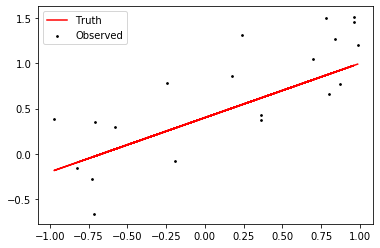

In [2]:
## generate 20 samples for training, and plot the corrupted data and truth data.
train_num = 20
N_list = [1, 3, train_num]
(X_extend, y_corrup, y_true), (X_test_extend, y_test_true), params = generate_dataset(train_num=20)
delta = 1      # noise level in target value
Sigma = np.eye(params.shape[0])  # coveriance matrix for parameters w

## visualize the generated dataset for training Bayesian regression
plt.scatter(X_extend[:, 0], y_corrup, s=3, color='k', label='Observed')
plt.plot(X_extend[:, 0], y_true, color='r', label='Truth')
plt.legend();

### 3.2 plot the results

We will use different amount of data to do Bayesian regression, we will see how bayesain regression converge to the *truth* values as the training data gets larger.

In [3]:
from scipy import stats

def plot_posterior(mean, cov, params, title=''):
    """ plot heat map of posterior distribution.
    """
    w0, w1 = params.tolist()
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    if title:
        plt.title(title)

    plt.xlabel('w0')
    plt.ylabel('w1')
    plt.legend()

def plot_posterior_sample(X, y_samples, X_N, y_N, truth):
    """ plot the predicted results from the sampled posterior distribution
    """
    plt.plot(X, y_samples[:, 0], 'r-', label='Post. samples')
    for idx in range(1, y_samples.shape[1]):
        plt.plot(X, y_samples[:, idx], 'r-')
    
    plt.scatter(X_N, y_N, s=3, color='k')
    plt.plot(truth[0], truth[1], 'k--', label='Truth')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.legend()


def plot_predictive(x, y, std, X_N, y_N, truth, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.diagonal().ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    plt.scatter(X_N, y_N, s=3, color='k')
    plt.plot(truth[0], truth[1], 'k--', label='Truth')
    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')
    
    plt.legend()
## --------------------------------------------------------- ##

def compute_posterior(X, y, delta, Sigma, return_inv=False):
    """ compute the posterior distribution of `params`.
    """
    A = delta**(-2) * X.T.dot(X) + np.linalg.inv(Sigma)
    A_inv = np.linalg.inv(A)
    mean = 1/delta**2 * (A_inv.dot(X.T)).dot(y)
    Cov = A_inv

    if return_inv:
        return mean, Cov, A_inv
    return mean, Cov

def compute_posterior_samples(X_test, mean, Cov, samp_num=5):
    """ compute the posterior distribution of `params`.
    """
    w_samples = np.random.multivariate_normal(mean.ravel(), Cov, samp_num)
    # X_test_extend = np.concatenate([X_test, np.ones((X_test.shape[0], 1))], axis=1)
    y_samples = X_test.dot(w_samples.T)
    return y_samples, w_samples

def compute_predictive_posterior(x_new, X, y, A_inv, delta):
    """ compute the predictive posterior distribution of test data.
    """
    mean = 1/delta**2 * ((x_new.dot(A_inv)).dot(X.T)).dot(y)
    Cov = (x_new.dot(A_inv)).dot(x_new.T)

    return mean, Cov

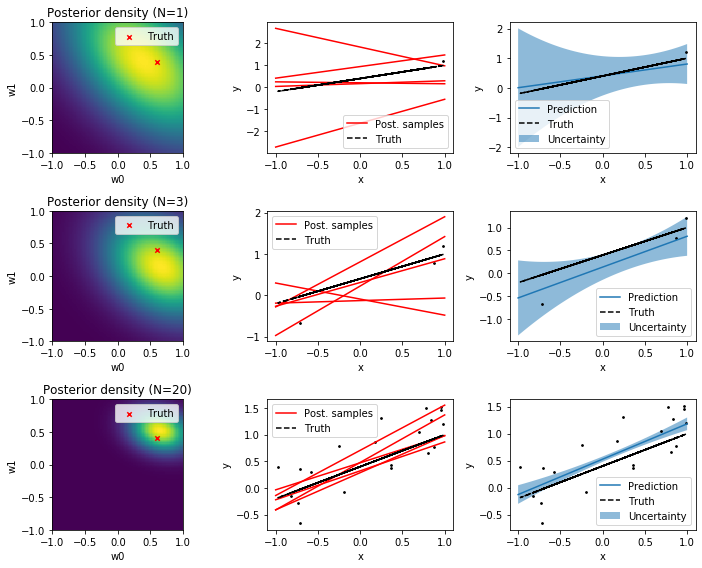

In [4]:
plt.figure(figsize=(10, 8))
for i, N in enumerate(N_list):
    X_train_N = X_extend[:N, :]
    y_N = y_corrup[:N]
    y_true_N = y_true[:N]

    # compute posterior distribution of `params`
    mean, Cov = compute_posterior(X_train_N, y_N, delta, Sigma)
    plt.subplot(len(N_list), 3, i*3+1)
    plot_posterior(mean, Cov, params, title=f'Posterior density (N={N})')

    # draw samples from the posterior distribution of `params`
    y_samples, w_samples = compute_posterior_samples(X_test_extend, mean, Cov, samp_num=5)
    plt.subplot(len(N_list), 3, i*3+2)
    plot_posterior_sample(X_test_extend[:, 0], y_samples, X_train_N[:, 0], y_N, (X_extend[:, 0], y_true))

    # draw predictive distribution
    mean, Cov = compute_predictive_posterior(X_test_extend, X_train_N, y_N, Cov, delta)
    plt.subplot(len(N_list), 3, i*3+3)
    plot_predictive(X_test_extend[:, 0], mean, Cov, X_train_N[:, 0], y_N, (X_extend[:, 0], y_true))

plt.tight_layout()

The first column of the figure above shows the posterior distribution of $\mathbf{w}$, we can see as the number of training data increases, the posterior distribution converges to the *Truth* value.

The second column shows the 5 predicted results using parameters sampled from the posterior distribution. As we can see, the posterior sampled results also converge to the *Truth* as more data are used.

The third column illustrate the predictive results as well as the uncertainty boundary.

### 3.3 Gaussian kernels